# Optimization
> Using `pydrake` to setup optimization problems.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pydrake.solvers import MathematicalProgram, IpoptSolver, Solve

__refs__:

- [mathematical_program|offical tutorial](https://deepnote.com/workspace/Drake-0b3b2c53-a7ad-441b-80f8-bf8350752305/project/Tutorials-2b4fc509-aef2-417d-a40d-6071dfed9199/notebook/mathematical_program-1bf36661e5964880a5a15374f5a4ae4c)
- [pydrake doc](https://drake.mit.edu/pydrake/pydrake.solvers.html?highlight=solve#module-pydrake.solvers)

## Mathematical program

Generic _mathemaical program_ can be stated as 
$$
\boxed{
\begin{align}
\min_x\ & f(x)\\
\text{s.t.}\ & x\in\mathcal{S}
\end{align}
}
$$
where $f(x)$ is an _objective function_, $x\in\mathbb{R}^n$ are _decision variables_ and $\mathcal{S}\subset\mathbb{R}^n$ is a _constraint set_.

`pydrake` supports multiple solvers for various categories of optimization problems. The `MathematicalProgram` class provides a common API to specify an optimization problem, e.g. objectives, constraints, and data structures, to avoid solver-specific codes (similar to YALMIP or JuMP in Julia).

Problems solvable by `pydrake`:

- Linear programming
- Quadratic programming
- Second-order cone programming
- Nonlinear nonconvex programming
- Semidefinite programming
- Sum-of-squares programming
- Mixed-integer programming (mixed-integer linear programming, mixed-integer quadratic programming, mixed-integer second-order cone programming).
- Linear complementarity problem

### Minimal examples

In [ ]:
# Set up the optimization problem
prog = MathematicalProgram()
# Decision variables
x = prog.NewContinuousVariables(2)
# Constraints
prog.AddConstraint(x[0] + x[1] == 1)
prog.AddConstraint(x[0] <= x[1])
# Objective function
prog.AddCost(x[0] **2 + x[1] ** 2)
# Solve
res = Solve(prog)

In [ ]:
(res.get_solver_id().name(),
 res.is_success(),
 res.get_solution_result(),
 res.GetSolution(x),
 res.get_optimal_cost())

('Clarabel',
 True,
 <SolutionResult.kSolutionFound: 0>,
 array([0.4999745, 0.5000255]),
 0.5000000013010027)

`pydrake` will automatically chooses a _solver_ for us, for more info see [here](https://drake.mit.edu/doxygen_cxx/group__solvers.html). Also, note that in the example above we do not specify the _initial guess_, by default it is set to zeros. We can pick a solver and suggest an initial guess as shown below.

In [ ]:
# Use IPOPT solver
solver = IpoptSolver()
# Suggest an initial guess
res = solver.Solve(prog, np.array([1, 1]))

(res.get_solver_id().name(),
 res.is_success(),
 res.get_solution_result(),
 res.GetSolution(x),
 res.get_optimal_cost())

('IPOPT',
 True,
 <SolutionResult.kSolutionFound: 0>,
 array([0.4999965, 0.5000035]),
 0.5000000000245315)

:::{.callout-tip apparance='simple' title=Callback}
Sometimes, it is usefull to see the intermediate values of the decision variables. We can use `.AddVisualizationCallback` to visualize/store/check those values.
:::

(array([3.00000077, 2.99999919]), 17.999999772313593)

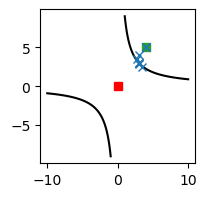

In [ ]:
fig, ax = plt.subplots(figsize=(2,2))
curve_x = np.linspace(1, 10, 100)
ax.plot(curve_x, 9./curve_x, 'k')
ax.plot(-curve_x, -9./curve_x, 'k')
ax.plot(0, 0, 'rs')
x0 = [4., 5.]
ax.plot(*x0, 'C2s')

def update(x):
    ax.plot(x[0], x[1], 'C0x')

# Find the closest point on a curve to the origin
prog = MathematicalProgram()
x = prog.NewContinuousVariables(2)
prog.AddConstraint(x[0] * x[1] == 9)
prog.AddCost(x[0]**2 + x[1]**2)
prog.AddVisualizationCallback(update, x)
res = Solve(prog, x0)
(res.GetSolution(), res.get_optimal_cost())  # analytical best at (3,3) or (-3,-3)

## Double integrator MPC

In [ ]:
# Double integrator
# xddot = u
def _dyn(x, u):
    return np.array([x[1], u])

# Forward Euler
def integrate(x, u, dt, t):
    _t = 0
    _x = x.copy()
    while _t < t:
        dx = _dyn(x, u)
        _x = _x + dx * dt
        _t += dt
    return _x
        
def apply_ctrls(x, u, dt=0.01):
    xs = [x.copy()]
    for ui in u:
        xs.append(integrate(xs[-1], ui, dt, 1.))
    return np.array(xs)
    
def cost_fn(u):
    xs = apply_ctrls(X, u)
    return (xs**2).sum()

In [ ]:
def mpc_one_step(u0, noise, solver):
    global X,U
    if solver is not None:
        res = solver.Solve(prog, u0)
        if res.get_solver_details().status != 0: return None
    else: 
        res = Solve(prog, u0, None)
        if not res.is_success(): return None
    U = res.GetSolution()
    X = integrate(X, U[0], 0.01, 1.)
    if noise is not None: X = X + np.random.randn(1) * noise
    return X.copy(), U.copy()

def mpc(n_step=10, noise=None, solver=None):
    global X,U
    xs,us = [X.copy()],[U.copy()]
    for step in range(n_step):
        res = mpc_one_step(U, noise, solver)
        if res is None: print(f'Solver fails, stops at {step}.'); break
        xs.append(res[0])
        us.append(res[1])
    return xs,us

In [ ]:
global X,U
X = np.array([-2,0.])         # initial (pos, velo)
U = np.zeros((n_horizen:=3))  # horizion

prog = MathematicalProgram()
u = prog.NewContinuousVariables(n_horizen, 'u')
prog.AddBoundingBoxConstraint(-5,5,u)
prog.AddCost(cost_fn, u)
# Do MPC for `n_step` steps,
# noise in observations, not in model
trajs = mpc((n_step:=10), solver=IpoptSolver(), noise=0.5)

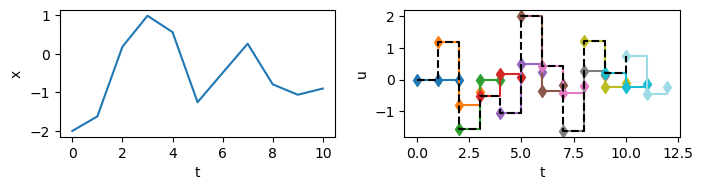

In [ ]:
#| echo: false
fig,axs = plt.subplots(1,2,figsize=(7,2))
colors = plt.get_cmap('tab20')(np.linspace(0,1,n_step+1))
xs = [o[0] for o in trajs[0]]

axs[0].plot(xs)
axs[0].set_xlabel('t')
axs[0].set_ylabel('x')

for i,us in enumerate(trajs[1]):
    axs[1].step(np.arange(n_horizen)+i, us, 'd-', c=colors[i], where='post')
us = [o[0] for o in trajs[1]]
axs[1].step(us, 'k--', where='post')
axs[1].set_xlabel('t')
axs[1].set_ylabel('u')
fig.tight_layout()